In [1]:
from ETC_import import *

import matplotlib
import matplotlib.pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()

from scipy import integrate

In [2]:
# User parameters

lambda_range = [300.,1100.]*u.nm

slit_w=0.5*u.arcsec
seeing_avg500nm = 1.1*u.arcsec  #FWHM
pivot = 500.*u.nm
airmass = 1.
#skybrightness

sourceModel = 'template'       # Choose from blackbody, template, other??
sourceType = 'nonstellar'      # Choose from nonstellar, novae, current_calspec
sourceFile = 'elliptical_001'  # Case sensitive; available from catalog

#sourceNorm = ???   # Normalize source flux e.g. to V-band AB mag
#sourceDiameter (arcsec) ???

detector_bin_spatial = 1
detector_bin_dispers = 1
#Nexposures = 1
#N_pix_h  #N pixels in spatial direction to use

#SNR = ?
# SNR or ETC (direction of calc)

In [20]:
### Only need to run this section to tabulate PSF integral and save it ###
#Sample and sum over 1 quadrant of Moffat profile (symmetric in x and y)
xstep=.01
binedges=np.arange(0,4+xstep/2.,xstep)
bincenters=np.arange(0,4,xstep) + xstep/2.

xx, yy = np.meshgrid(bincenters,bincenters)
m = Moffat_scalefree(xx,yy)

# Make 2D array with extra row and col of zeros
# Extra zeros will be value of the integral when limits are zero
mcum = np.zeros((len(m)+1,len(m)+1))
mcum[1:,1:] = m.cumsum(axis=0).cumsum(axis=1)/m.sum() #Tabulates PSF cumulative sum from center out in 2D


PSFsum2D = interp2d(binedges ,binedges ,mcum ,bounds_error=False) #allows out of bounds arguments -> nearest neighbor
pickle.dump(PSFsum2D ,open('/home/developer/Software/ETC/PSFsum2D.pkl' ,'ab'))
#pkfile.close()

#PSFsum2D = pickle.load(open(PSFsum2DFile ,'rb'))


In [21]:
PSFsum2D([0,.015,1,2,4],4)  #dx=.01

array([0.        , 0.03176046, 0.97322772, 0.99929174, 1.        ])

In [22]:
# USING TABULATED MOFFAT INTEGRAL TO BACK OUT PIXELIZED SOURCE (diagnostic; not used in ETC)

channel='G'

# Step through integer pixel widths
x = rangeQ(0*u.pix,20*u.pix)
x=x.to('arcsec' ,equivalencies=plate_scale[channel])
print('pixel size',x[1])

lams = rangeQ(300*u.nm,1200*u.nm,200*u.nm)

image = None

for j in 1+np.arange(len(x)-1):
#for j in 1+np.arange(3):
    
    rowj = []
    for i in range(len(x)-1):
        outerint = slitFractions(lams, 2*x[i+1] ,2*x[j] ,seeing_avg500nm)
        innerint = slitFractions(lams, 2*x[i] ,2*x[j] ,seeing_avg500nm)
        rowj.append(outerint['center']-innerint['center'])
    rowj = np.array(rowj).T  # shape is (Nlambda,Npix)
            
    if image is None:
        image = rowj[:,:,np.newaxis] # shape is (Nlambda,Npix,1)
    else:
        rowj = rowj - image.sum(2)  #sum over previous rows
        image = np.dstack([image,rowj]) # shape is (Nlambda,Npix,j)

print(image.shape)
print(image.sum(axis=(1,2)))  #SHOULD EQUAL 1 for each lamdba

pixel size 0.191 arcsec
(5, 19, 19)
[0.99988654 0.99976133 0.99962048 0.99946866 0.9993086 ]


Text(0.5, 1.0, '1100.0 nm')

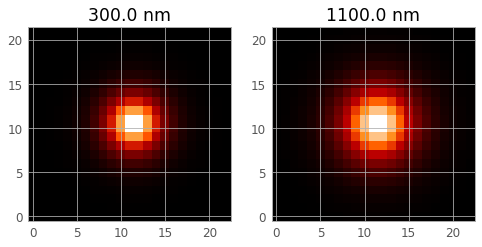

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('Horizontally stacked subplots')
stampsize=10

i=0
bigimage = np.hstack([image[i,:stampsize+1,stampsize+1::-1],image[i,:stampsize+1,:stampsize+1]])
bigimage = np.vstack([bigimage[::-1],bigimage])
ax1.imshow(bigimage ,origin='lower')
ax1.set_title(str(lams[i]))

i=-1
bigimage = np.hstack([image[i,:stampsize+1,stampsize+1::-1],image[i,:stampsize+1,:stampsize+1]])
bigimage = np.vstack([bigimage[::-1],bigimage])
ax2.imshow(bigimage ,origin='lower')
ax2.set_title(str(lams[i]))

In [24]:
print(image[2,:5,:5])  #NOT QUITE SYMMETRIC

[[0.07515149 0.06462774 0.04843152 0.03236301 0.01981953]
 [0.06462774 0.05582835 0.04218437 0.02849505 0.01766279]
 [0.04843152 0.04218437 0.03236347 0.02230309 0.01413904]
 [0.03236301 0.02849505 0.02230309 0.01578323 0.01031133]
 [0.01981953 0.01766279 0.01413904 0.01031133 0.00697296]]


In [304]:
print(image[2,:5,:5])  #NOT QUITE SYMMETRIC

[[0.10328047 0.0835164  0.05639302 0.03300469 0.01751566]
 [0.08408639 0.06857261 0.04700438 0.02803357 0.01517793]
 [0.05677688 0.04700438 0.03310025 0.02042503 0.01146919]
 [0.03322859 0.02803357 0.02042503 0.01316483 0.00775074]
 [0.01763407 0.01517793 0.01146919 0.00775074 0.0048085 ]]


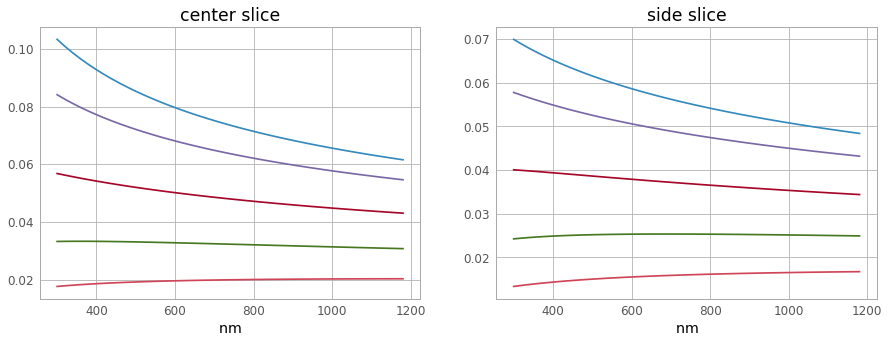

In [433]:
fig, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(15,5))

# 1st pixels from origin for all wavelengths (slit)
for i in range(5):
    ax1.plot(lams,profile_center[i])
    ax1.set_title('center slice')
    ax2.plot(lams,profile_side[i])
    ax2.set_title('side slice')

In [158]:
## LSF ##

#1/2 of FWHM requirement --> sigma
LSFsigma={
    'U': 1.0/2/2.35*u.AA,
    'G': 1.4/2/2.35*u.AA,
    'R': 1.85/2/2.35*u.AA,
    'I': 2.25/2/2.35*u.AA,
}

from synphot.models import Empirical1D, Gaussian1D, Box1D

kernel_upsample,kernel_range = (5,4)

# Multiply approximate seeing profile with slit "tophat"
ch = 'R'
midlam = channelRange[ch].mean()
s = seeingLambda(midlam ,seeing_avg500nm)/2.35
s_lam = s.to('pix', equivalencies=plate_scale['R']).to(u.AA ,equivalencies=dispersion_scale['R'])
slit_w_lambda=slit_w.to('pix', equivalencies=plate_scale['R']).to(u.AA ,equivalencies=dispersion_scale['R'])

slitLSF = Gaussian1D(stddev=s_lam)*Box1D(width=slit_w_lambda)

# Not ideal if slit width >> seeing
kernel_range = slit_w_lambda/2 + LSFsigma[ch]*kernel_range

# MIN of seeing and slit sets the slit scale; MAX of slit and instument sets total scale
dlamda = max(min(s_lam, slit_w_lambda/2.) ,LSFsigma[ch])/kernel_upsample

## KERNEL RANGE MUST HAVE 0 IN THE EXACT CENTER (need odd array length)
xk = rangeQ(0.*dlamda,kernel_range+dlamda,dlamda)
xk = np.hstack((-xk[::-1],xk[1:]))  # Symmetrizes range, e.g. [-2,-1,0,1,2]

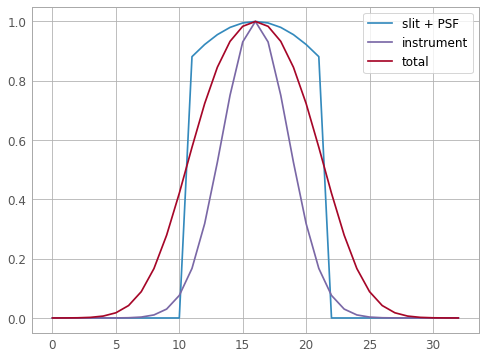

In [159]:
lamdamin, lamdamax = spectrum.waverange
x = rangeQ(lamdamin ,lamdamax ,dlamda)

# Dimensionless arrays for use with convolve; BEWARE of boundary behavior
# convolve(mode=same) matches size of 1st argument
kernel1 = slitLSF(xk).value
kernel2 = Gaussian1D(amplitude=1. ,mean=0.*u.AA ,stddev=LSFsigma[ch])(xk).value

kernel = convolve(kernel1, kernel2, mode='same', method='auto')

plt.plot(kernel1 ,label='slit + PSF')
plt.plot(kernel2 ,label='instrument')
plt.plot(kernel/kernel.max() ,label='total')
plt.legend()

In [3]:
from ETC_import import _convolveLSF
sky = LoadCSVSpec(skybackground_file)
spectrum = sky

newspec = _convolveLSF(sky, slit_w ,seeing_avg500nm ,'R' ,pivot=pivot)

[561. 794.] nm


(0.0, 7.0)

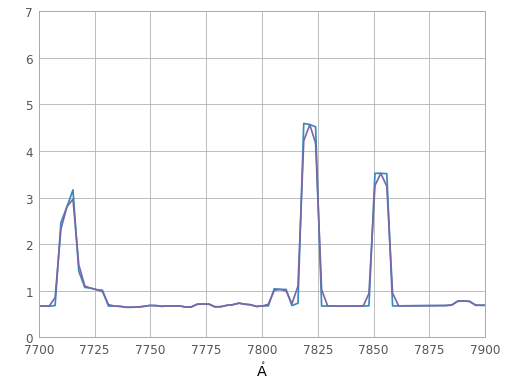

In [19]:
x = sky.waveset
plt.plot(x,sky(x))
plt.plot(x,newspec(x))
print(channelRange['R'])
plt.xlim(7700,7900)
#plt.xlim(channelRange['R'])
plt.ylim(0,7)